In [1]:
# MSIT 3103 — Environment setup (run this cell once per machine)
# Installs/updates the required packages into the same Python used by this notebook

import sys
print(f"Using Python {sys.version.split()[0]}")

# Install required packages into the current notebook environment
%pip install -qU numpy matplotlib scikit-learn

# Verify versions
import numpy as np, matplotlib, sklearn
print("numpy       :", np.__version__)
print("matplotlib  :", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("✅ Setup complete!")


Using Python 3.10.19
Note: you may need to restart the kernel to use updated packages.
numpy       : 2.2.6
matplotlib  : 3.10.8
scikit-learn: 1.7.2
✅ Setup complete!


# Assignment 1: Foundations Reflection - Hot Start

## Discriminative vs. Generative Models
This notebook implements and contrasts two fundamental AI model types on a simple, well‑known dataset. A **logistic regression** classifier acts as our discriminative model, while a **basic generative adversarial network (GAN)** implemented from scratch serves as our generative model. By training these models on the same data, we can observe differences in their training dynamics, performance and behaviour.

## Dataset: Handwritten Digits (8×8)
The [digits](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset) dataset from scikit‑learn contains 1,797 samples of handwritten digits with8×8 pixels each.  Each pixel value ranges between 0 and 16.  We normalisethese values to the range \([-1,1]\) for the GAN and to \([0,1]\) for logisticregression.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Load the dataset
digits = load_digits()
X = digits.data.copy()  # shape (1797, 64)
y = digits.target.copy()

# For logistic regression we normalise pixel values to [0,1]
X_lr = X / 16.0
# For the GAN we normalise pixel values to [−1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_gan = scaler.fit_transform(X)

print(f'Dataset shape: {X.shape}, labels: {np.unique(y)}')


Matplotlib is building the font cache; this may take a moment.


Dataset shape: (1797, 64), labels: [0 1 2 3 4 5 6 7 8 9]


### Visualising sample digits
Below we plot a handful of digits from the dataset.  This provides anintuition for the data we will feed into both models.  Each image isdisplayed as an 8×8 grid of grayscale pixels.

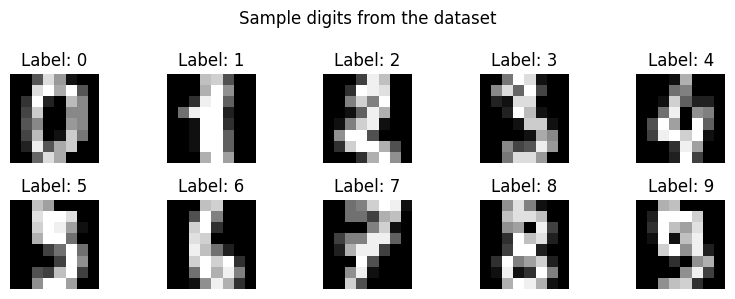

In [3]:
# Plot the first 10 digits
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.suptitle('Sample digits from the dataset')
plt.tight_layout()
plt.show()


### Dataset observations (Handwritten Digits 8×8)

The dataset consists of low-resolution (8×8) grayscale images of handwritten digits.
Despite the coarse resolution, most digit classes are visually distinguishable.
However, some digits show similar stroke patterns at this scale, which may lead to
classification ambiguity.

Because the data is relatively simple and compact, it is well suited for a linear
classifier such as logistic regression. At the same time, the simplicity of the
dataset allows a basic GAN to learn the overall digit structure without excessive
computational cost.


## Discriminative Model: Logistic Regression
Logistic regression is a linear classifier that models the probability ofeach class using a softmax function.  It is trained via maximum likelihoodto separate classes based on input features.  Here we train it on atrain/test split of the digits dataset and report standard classificationmetrics.

Logistic regression test accuracy: 0.9556
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.88      0.83      0.86        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.92      1.00      0.96        36
           5       0.97      1.00      0.99        37
           6       0.97      0.94      0.96        36
           7       0.97      1.00      0.99        36
           8       0.91      0.89      0.90        35
           9       0.94      0.92      0.93        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.95       360
weighted avg       0.96      0.96      0.96       360



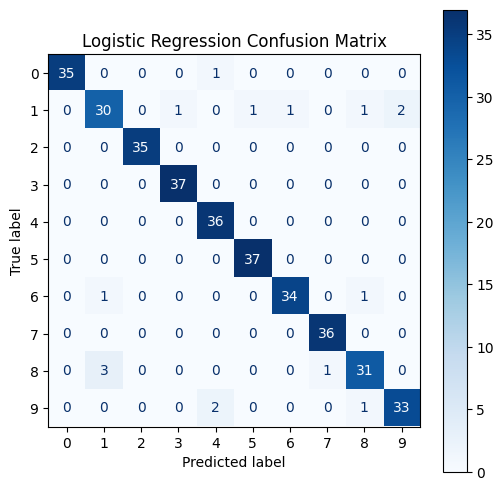

In [4]:
# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y, test_size=0.2, random_state=42, stratify=y
)

# Instantiate and train logistic regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

# Evaluate on the test set
y_pred_lr = lr_model.predict(X_test_lr)
accuracy = (y_pred_lr == y_test_lr).mean()
print(f'Logistic regression test accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test_lr, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


### Observations

The logistic regression classifier achieves strong performance on this dataset, with
a test accuracy of approximately **95.6%**. The confusion matrix exhibits a dominant
diagonal structure, indicating that most digit classes are classified correctly.

Despite the high overall accuracy, some misclassifications occur between visually
similar digits at low resolution. Notably, several samples of digit **8** are
misclassified as **1**, which likely occurs when the loop structures of the 8 are
blurred or lost at 8×8 resolution, leaving a dominant vertical stroke pattern.
Additionally, a small number of digit **9** samples are misclassified as **4**, likely
because a weak or incomplete loop in the 9 causes it to resemble a vertical-stroke-
dominated 4.

These errors highlight the limitations of a linear discriminative model operating on
low-resolution, flattened pixel inputs. While logistic regression effectively learns
decision boundaries between classes, it cannot capture higher-level shape structures
or spatial relationships within the images.


## Generative Model: Simple GAN implemented in NumPy
A generative adversarial network consists of two neural networks — a generator $G$ and a discriminator $D$ — that play a minimax game. The generator receives random noise as input and tries to produce outputs that resemble real images; the discriminator learns to distinguish real datafrom generated data. During training, $D$ is optimised to maximize the probability of correctly classifying real versus generated images, while $G$ is optimized to fool $D$. In this notebook we implement a very small GAN from scratch using NumPy without the aid of deep‑learning frameworks. Due to the simplicity of the architecture and the low‑resolution dataset, the generated images do not achieve human‑level quality, but the exercise illustrates training dynamics and highlights challenge ssuch as instability and slow convergence.

Step 500/1500, loss_D=0.9796, loss_G=0.6747
Step 1000/1500, loss_D=0.8473, loss_G=0.7130
Step 1500/1500, loss_D=0.8148, loss_G=0.6961


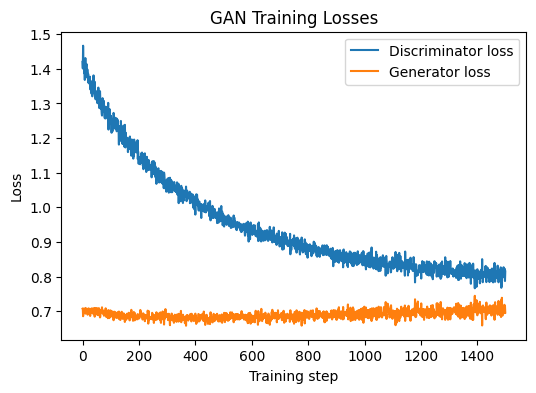

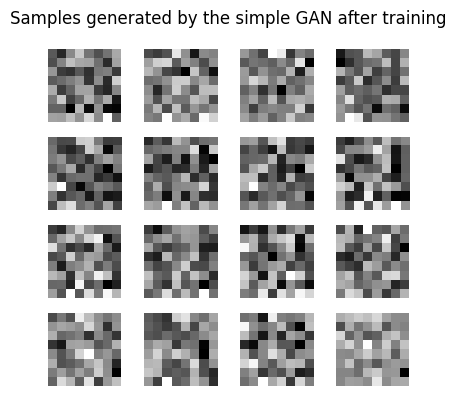

In [5]:
# Parameters for the simple GAN
noise_dim = 20
hidden_dim_g = 64
hidden_dim_d = 64
batch_size = 64
learning_rate_d = 0.0005
learning_rate_g = 0.0005
num_steps = 1500  # keep the number of steps modest to run quickly

# Initialise weights for generator and discriminator
rng = np.random.default_rng(seed=42)
# Generator weights
W1_g = rng.normal(0, 0.1, size=(noise_dim, hidden_dim_g))
b1_g = np.zeros(hidden_dim_g)
W2_g = rng.normal(0, 0.1, size=(hidden_dim_g, X_gan.shape[1]))
b2_g = np.zeros(X_gan.shape[1])
# Discriminator weights
W1_d = rng.normal(0, 0.1, size=(X_gan.shape[1], hidden_dim_d))
b1_d = np.zeros(hidden_dim_d)
W2_d = rng.normal(0, 0.1, size=(hidden_dim_d, 1))
b2_d = np.zeros(1)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Lists to record losses for plotting
losses_d = []
losses_g = []

# Training loop
for step in range(num_steps):
    # Sample a minibatch of real images
    idx = rng.choice(len(X_gan), size=batch_size, replace=False)
    real_batch = X_gan[idx]
    # Sample random noise
    z = rng.normal(0, 1, size=(batch_size, noise_dim))
    # -------- Generator forward pass --------
    g_h_pre = z @ W1_g + b1_g
    g_h = np.maximum(0, g_h_pre)
    g_pre = g_h @ W2_g + b2_g
    fake_batch = np.tanh(g_pre)
    # -------- Discriminator forward pass on real images --------
    d_h_pre_real = real_batch @ W1_d + b1_d
    d_h_real = np.maximum(0, d_h_pre_real)
    d_logits_real = d_h_real @ W2_d + b2_d
    d_out_real = sigmoid(d_logits_real)
    # -------- Discriminator forward pass on fake images --------
    d_h_pre_fake = fake_batch @ W1_d + b1_d
    d_h_fake = np.maximum(0, d_h_pre_fake)
    d_logits_fake = d_h_fake @ W2_d + b2_d
    d_out_fake = sigmoid(d_logits_fake)
    # -------- Discriminator loss and gradients --------
    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))
    d_delta_real = (d_out_real - y_real) / batch_size
    d_delta_fake = (d_out_fake - y_fake) / batch_size
    grad_W2_d = d_h_real.T @ d_delta_real + d_h_fake.T @ d_delta_fake
    grad_b2_d = np.sum(d_delta_real + d_delta_fake, axis=0)
    d_grad_h_real = d_delta_real @ W2_d.T
    d_grad_h_real[d_h_pre_real <= 0] = 0
    d_grad_h_fake = d_delta_fake @ W2_d.T
    d_grad_h_fake[d_h_pre_fake <= 0] = 0
    grad_W1_d = real_batch.T @ d_grad_h_real + fake_batch.T @ d_grad_h_fake
    grad_b1_d = np.sum(d_grad_h_real + d_grad_h_fake, axis=0)
    # Update discriminator parameters
    W2_d -= learning_rate_d * grad_W2_d
    b2_d -= learning_rate_d * grad_b2_d
    W1_d -= learning_rate_d * grad_W1_d
    b1_d -= learning_rate_d * grad_b1_d
    # -------- Generator loss and gradients --------
    y_gen = np.ones((batch_size, 1))
    loss_g = -np.mean(np.log(d_out_fake + 1e-8))
    g_delta_d = (d_out_fake - y_gen) / batch_size
    g_grad_h_fake = g_delta_d @ W2_d.T
    g_grad_h_fake[d_h_pre_fake <= 0] = 0
    grad_fake_input = g_grad_h_fake @ W1_d.T
    grad_g_pre = grad_fake_input * (1 - fake_batch ** 2)
    grad_W2_g = g_h.T @ grad_g_pre
    grad_b2_g = np.sum(grad_g_pre, axis=0)
    g_grad_h = grad_g_pre @ W2_g.T
    g_grad_h[g_h_pre <= 0] = 0
    grad_W1_g = z.T @ g_grad_h
    grad_b1_g = np.sum(g_grad_h, axis=0)
    # Update generator parameters
    W2_g -= learning_rate_g * grad_W2_g
    b2_g -= learning_rate_g * grad_b2_g
    W1_g -= learning_rate_g * grad_W1_g
    b1_g -= learning_rate_g * grad_b1_g
    # Record losses
    losses_d.append(loss_d)
    losses_g.append(loss_g)
    if (step + 1) % 500 == 0:
        print(f'Step {step+1}/{num_steps}, loss_D={loss_d:.4f}, loss_G={loss_g:.4f}')

# After training, generate a batch of images for visualisation
z_sample = rng.normal(0, 1, size=(16, noise_dim))
g_h_pre = z_sample @ W1_g + b1_g
g_h = np.maximum(0, g_h_pre)
g_pre = g_h @ W2_g + b2_g
fake_samples = np.tanh(g_pre)

# Plot generator and discriminator loss curves
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(losses_d, label='Discriminator loss')
ax.plot(losses_g, label='Generator loss')
ax.set_xlabel('Training step')
ax.set_ylabel('Loss')
ax.set_title('GAN Training Losses')
ax.legend()
plt.show()

# Visualise generated samples as 8×8 images
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_samples[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle('Samples generated by the simple GAN after training')
plt.tight_layout()
plt.show()


### Observations on GAN training

During training, the discriminator and generator losses exhibit oscillatory behavior,
reflecting the adversarial nature of GAN optimization. Unlike logistic regression,
there is no clear notion of convergence to a single optimum; instead, both networks
continuously adapt to one another.

Although the discriminator loss decreases overall, the generator loss remains relatively
stable and does not translate into high-quality visual outputs. The generated samples
after training still resemble structured noise rather than clearly recognizable digits.
This indicates that, with the simple fully connected architecture and limited number of
training steps, the generator struggles to capture the underlying structure of the digit
distribution.

These results highlight a key challenge of generative models: training stability and
output quality are highly sensitive to model capacity, architecture choice, and training
duration. Nevertheless, this simple GAN demonstrates the core idea of generative
modeling, where the generator improves by receiving feedback from the discriminator,
rather than relying on labeled data.


## Comparison and Reflection

The discriminative logistic regression model achieved strong classification performance
(~95.6% test accuracy) on the digits dataset with a straightforward and stable training
process. Its objective is to learn a mapping from inputs to labels (i.e., estimate
P(y|x)), so evaluation is direct using accuracy, precision/recall, and the confusion
matrix. Most errors can be explained by low-resolution ambiguity (e.g., some 8→1 and
9→4 confusions), but overall the model converges reliably.

In contrast, the GAN is a generative model that aims to learn the data distribution
P(x) in order to create new samples. Training involves a minimax game between the
generator and discriminator, so the dynamics are inherently less stable and harder to
interpret. Even when loss curves appear to move in a reasonable direction, the quality
of generated samples may remain poor. In this run, the generator outputs largely
resembled structured noise rather than clearly recognizable digits, showing that
limited model capacity and short training can prevent the GAN from capturing the true
digit structure.

These differences have important practical implications. Discriminative models like
logistic regression are preferable when the goal is accurate prediction with clear,
quantitative evaluation (e.g., medical classification, fraud detection, spam filtering).
Generative models like GANs are preferable when producing new data is valuable (e.g.,
data augmentation, synthetic data generation, creative content). However, generative
models require more careful tuning and are typically evaluated with both qualitative
inspection and specialized metrics, making them more complex to train and validate.


## Conclusion

In this assignment, a discriminative model (logistic regression) and a generative model
(GAN) were implemented and compared using the same handwritten digits dataset. Logistic
regression achieved strong and stable classification performance, with clear and
interpretable evaluation metrics such as accuracy and the confusion matrix. Its training
process converged reliably, making it well suited for tasks where accurate prediction
and transparency are required.

In contrast, the GAN demonstrated the core ideas of generative modeling but also
highlighted its challenges. Training was less stable, loss values were harder to
interpret, and the generated samples did not clearly resemble real digits given the
simple architecture and limited training. Nevertheless, the GAN illustrates how models
can learn to approximate a data distribution and generate new samples without labeled
data.

Overall, this comparison shows that discriminative models are preferable for reliable
classification tasks, while generative models are more suitable for applications where
data synthesis, augmentation, or creative generation is desired. The choice between
these model types depends on the problem requirements, available data, and tolerance
for training complexity and instability.


# Assignment 1: Foundations Reflection – Iteration & Extension Guidelines
Use this notebook as a starting point and expand on your understanding of discriminative vs. generative models by completing the following structured tasks. You are encouraged to experiment, analyze, and critically reflect on your findings in your report.

## Part 1 – Discriminative Model (Logistic Regression) Extensions
1. Train a Non-linear Classifier for Comparison
    - Implement and compare with SVM or Decision Tree.
    - Analyze classification performance vs. logistic regression.

2. Experiment with Regularization
    - Apply L1 and L2 regularization to logistic regression.
    - Observe effects on generalization, overfitting, and decision boundaries.

3. Feature Importance Visualization
    - Visualize learned weight matrix for each class (e.g., as an 8×8 heatmap).
    - Reflect on what the model focuses on per class.

4. Use Cross-Validation
    - Replace train/test split with 5-fold or 10-fold cross-validation.
    - Report mean accuracy, standard deviation, and robustness insights.

## Part 2 – Generative Model (GAN) Extensions
5. Hyperparameter Sensitivity
    - Vary batch size, learning rate, and hidden layer size.
    - Track and explain training stability and output quality.

6. Visualize Training Progress
    - Save generator outputs at fixed intervals (e.g., every 500 steps).
    - Show how image quality improves (or worsens) over time.

7. Plot and Interpret Loss Curves
    - Plot loss_D and loss_G vs. iteration number.
    - Comment on training dynamics, instability, or signs of convergence.

8. Mode Collapse Experiment
    - Purposely use unstable hyperparameters to induce collapse.
    - Describe how outputs degenerate and why this occurs.

9. Modify GAN Architecture
    - Play with model parameters to achieve lower generative loss.
    - Analyze impact on learning capacity and output diversity.

## Part 3 – Comparative Analysis & Meta Reflection
10. Contrast the Nature of Tasks
    - Discuss differences in training goals: classification vs. generation.
    - Reflect on why GAN is inherently harder to train.

11. Use Generated Images as Synthetic Data
    - Train logistic regression on fake data generated by GAN.
    - Evaluate how well it performs on real test data (domain gap analysis).

12. Latent Space Interpolation
    - Linearly interpolate between two random noise vectors.
    - Visualize how the generated images morph; assess continuity.

13. Literature-Informed Critique of GAN Training
    - Read and cite at least one paper on GAN instability (e.g., Goodfellow et al., or Salimans et al.).
    - Comment on observed instabilities in your own training runs.

## Part 4 – Reporting Expectations
14. Visualizations
    - Include plots: accuracy curves, loss curves, GAN outputs over epochs.

15. Comparative Tables
    - Tabulate training time, accuracy, convergence speed, and qualitative results.

16. Critical Reflections
    - Which model was easier to debug?

17. How does each model handle complexity?
    - In what scenarios would one model be clearly preferred?

## 🌟 Bonus (Optional Advanced Ideas)
18. Use a Deep Convolutional GAN (DCGAN)
    - Implement using PyTorch or TensorFlow for better image quality.

19. Compare with a Variational Autoencoder (VAE)
    - Explore a probabilistic generative model for a richer comparison.

20. Try Training on a Subset of CIFAR-10
    - Use only 2–3 classes and observe how the GAN performs on RGB data.
